In [61]:
#importing pandas and matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#allowing graphs in the program
%matplotlib inline

#importing data as data frames
df_construct=pd.read_csv('ConstructionTimeSeriesDataV2.csv')

In [4]:
df_construct.head()

,Month,Month-Year,Total Construction,Private Construction,Public Construction
0,1,Jan-02,59516,45273,14243
1,2,Feb-02,58588,44475,14113
2,3,Mar-02,63782,49396,14386
3,4,Apr-02,69504,53283,16221
4,5,May-02,73384,55009,18375


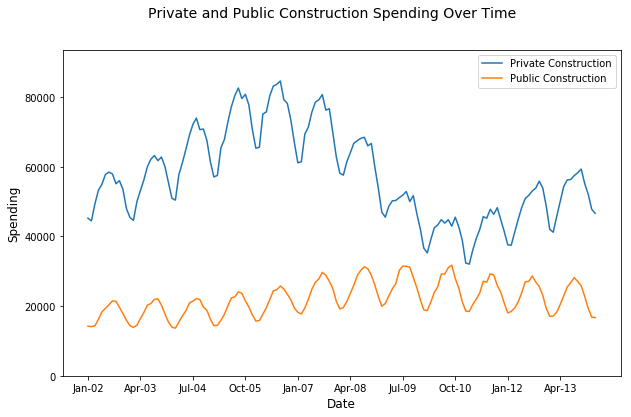

In [62]:
fig,ax=plt.subplots()
ax.plot(df_construct['Month-Year'],df_construct['Private Construction'])
ax.plot(df_construct['Month-Year'],df_construct['Public Construction'])

ax.set_ylim(0,max(df_construct['Private Construction'])+9000)
ax.legend(loc=1)
ax.set_xticks(df_construct['Month-Year'][::15])
ax.set_xticklabels(df_construct['Month-Year'][::15])

fig.set_size_inches(10,6)
fig.suptitle('Private and Public Construction Spending Over Time',size='14')
ax.set_xlabel('Date', size='12')
ax.set_ylabel('Spending', size='12')
plt.show()


Average Squared Error per Month:  33423096.990961365
            Month Month-Year  Total Construction  Private Construction  \
2003-06-30     18     Jun-03               80377                 60076   
2003-07-31     19     Jul-03               82971                 62216   
2003-08-31     20     Aug-03               85191                 63234   
2003-09-30     21     Sep-03               83841                 61767   
2003-10-31     22     Oct-03               83133                 62813   
2003-11-30     23     Nov-03               77915                 60115   
2003-12-31     24     Dec-03               71050                 55584   
2004-01-31     25     Jan-04               64934                 50975   
2004-02-29     26     Feb-04               64138                 50449   
2004-03-31     27     Mar-04               73238                 57796   
2004-04-30     28     Apr-04               78354                 61177   
2004-05-31     29     May-04               83736           

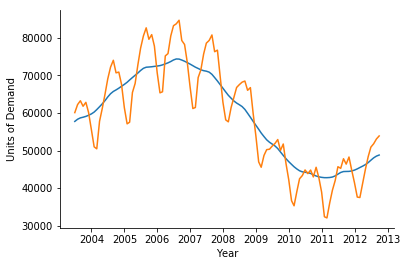

In [64]:
def sqErr(row):
    return (row['PriConstruct'] - row['MovAvg'])**2
    
df_construct['MovAvg'] = np.NaN
df_construct['sqErr'] = np.NaN
df_construct.index = pd.DatetimeIndex(freq='m', start=pd.Timestamp(year=2002, month=1, day=31), periods = len(df_construct['Month-Year']))

window = 35
window = window - window % 2
for i in range(int(window/2),df_construct.shape[0]-int(window/2)):
    df_construct.loc[df_construct.index[i],'MovAvg'] = (0.5*df_construct.iloc[i - int(window/2)]['Private Construction'] + \
                                                        df_construct.iloc[i - int(window/2)+1:i + int(window/2)]['Private Construction']\
                                                        .sum() + 0.5*df_construct.iloc[i + int(window/2)]['Private Construction'])/float(window)

df_construct['sqErr'] = (df_construct['Private Construction'] - df_construct['MovAvg'])**2

df_construct.dropna(how='any',inplace=True)

fig,ax = plt.subplots()
ax.plot(df_construct['MovAvg'],label='Moving Avg.')
ax.plot(df_construct['Private Construction'])
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Squared Error per Month: ',sum(df_construct['sqErr'])/len(df_construct))
print(df_construct)

In [65]:
df_construct['R1'] = df_construct['Private Construction'] - df_construct['MovAvg']
df_construct['R1Error'] = abs((df_construct['Private Construction'] - df_construct['R1'])/df_construct['Private Construction'])
df_construct.style.format({
    'MovAvg': '{:.1f}'.format,
    'sqErr': '{:,.1f}'.format,
    'R1': '{:,.1f}'.format,
    'R1Error': '{:,.3f}'.format
})

,Month,Month-Year,Total Construction,Private Construction,Public Construction,MovAvg,sqErr,R1,R1Error
2003-06-30 00:00:00,18,Jun-03,80377,60076,20301,57738.9,"5,462,118.9","2,337.1",0.961
2003-07-31 00:00:00,19,Jul-03,82971,62216,20755,58316.5,"15,206,444.3","3,899.5",0.937
2003-08-31 00:00:00,20,Aug-03,85191,63234,21957,58679.1,"20,746,953.2","4,554.9",0.928
2003-09-30 00:00:00,21,Sep-03,83841,61767,22075,58854.8,"8,480,943.1","2,912.2",0.953
2003-10-31 00:00:00,22,Oct-03,83133,62813,20321,59070.4,"14,006,746.5","3,742.6",0.940
2003-11-30 00:00:00,23,Nov-03,77915,60115,17801,59371.1,"553,404.7",743.9,0.988
2003-12-31 00:00:00,24,Dec-03,71050,55584,15466,59729.9,"17,188,096.6","-4,145.9",1.075
2004-01-31 00:00:00,25,Jan-04,64934,50975,13959,60225.0,"85,563,316.2","-9,250.0",1.181
2004-02-29 00:00:00,26,Feb-04,64138,50449,13689,60881.3,"108,833,681.1","-10,432.3",1.207
2004-03-31 00:00:00,27,Mar-04,73238,57796,15443,61645.0,"14,814,801.0","-3,849.0",1.067


Average Residual:  168.9751838235296


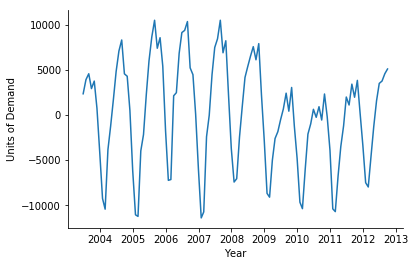

In [66]:
fig,ax = plt.subplots()
ax.plot(df_construct['R1'])
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Residual: ', sum(df_construct['R1'])/len(df_construct))

In [48]:
maxCorr = 0.0
period = np.NaN
for i in range(1,37):
    corr = df_construct['R1'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

Correlation, lag  1     0.8566036906708372
Correlation, lag  2     0.5883243627486128
Correlation, lag  3     0.26409660652542344
Correlation, lag  4     -0.00938795255291346
Correlation, lag  5     -0.2043037982673861
Correlation, lag  6     -0.29486699030108865
Correlation, lag  7     -0.21983051967822612
Correlation, lag  8     -0.05181702425182889
Correlation, lag  9     0.19983299674413582
Correlation, lag  10     0.4953198761443329
Correlation, lag  11     0.7345092921933132
Correlation, lag  12     0.8583406560789764
Correlation, lag  13     0.7182349519793707
Correlation, lag  14     0.46045703259812093
Correlation, lag  15     0.13616635712725697
Correlation, lag  16     -0.13781500167263924
Correlation, lag  17     -0.33879974775378363
Correlation, lag  18     -0.44084817663501874
Correlation, lag  19     -0.3772981673109749
Correlation, lag  20     -0.22184342857100395
Correlation, lag  21     0.03379790471952209
Correlation, lag  22     0.34521274052861445
Correlation, lag 

In [67]:
period = 12
cycleLen = period
numCycles = int(len(df_construct)/cycleLen + 0.5)
cycles = [df_construct.iloc[range(i*period,min((i+1)*period,len(df_construct)))]['R1'] for i in range(numCycles)]
ptsInCycles = [df_construct.iloc[range(i,len(df_construct['R1']),period)]['R1'].tolist() for i in range(period)]
avg = [sum(pts)/len(pts) for pts in ptsInCycles]

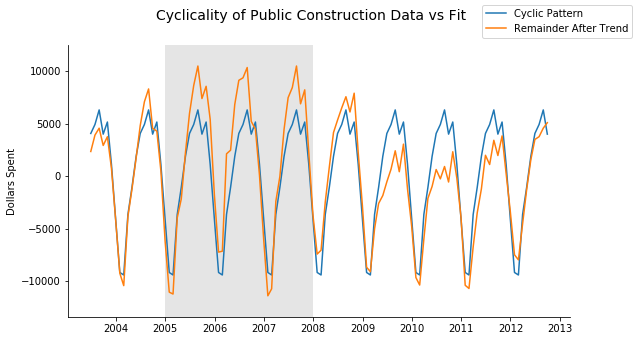

In [104]:
cycleLen = period   # see prior cell for computation of cyclicality period
numCycles = int(len(df_construct)/cycleLen + 0.5)
df_construct['C'] = np.NaN   # Creates an empty column for the cyclicality component data
for i in range(len(df_construct)):
    df_construct.loc[df_construct.index[i], 'C'] = avg[i % cycleLen] # Write appropriate cyclicality value

fig,ax = plt.subplots()
fig.suptitle('Cyclicality of Public Construction Data vs Fit', size='14')
fig.set_size_inches(9,5)
ax.plot(df_construct['C'],label='Cyclic Pattern')
ax.plot(df_construct['R1'],label='Remainder After Trend')
#ax.set_xlabel('Year')
ax.set_ylabel('Dollars Spent')
ax.set_ylim(min(df_construct['R1'])-2000,max(df_construct['R1'])+2000)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axvspan('2005','2008',facecolor='k',alpha=0.1)
fig.legend(loc=1)

In extracting the cyclicality component, we see the spending on private construction exceeds that which was predicted in the model between 2005 and 2008.  